<a href="https://colab.research.google.com/github/sudheerpunuri82/Facial-Emotion-Recognition-FER-using-Transfer-Learning/blob/main/efficientnet_xgboost_CKPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from google.colab import drive

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB5,EfficientNetB6,EfficientNetB7
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):
    """
    Vizualize the distribution of the dataset.

    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category

    Returns:
        No value
    """

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="#Images");
    ax.grid()


def load_data(data_path):
    """
    Load the dataset to the memory.

    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts

    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)

        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            face_array=cv2.resize(pixels, None, fx=1, fy=1,interpolation = cv2.INTER_CUBIC)

            img_data_list.append(face_array)
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels, 6)
    data = np.array(img_data_list)

    data_visualization(subfolders_ck, num_images_per_class)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 135 images of category 0
Loading : 177 images of category 1
Loading : 75 images of category 2
Loading : 207 images of category 3
Loading : 84 images of category 4
Loading : 249 images of category 5

Total number of uploaded data:  927 , with data shape (48, 48, 3)


(927, 6)

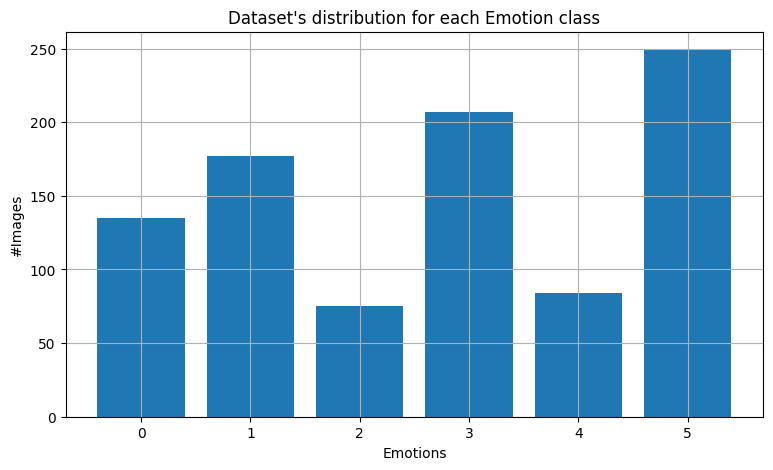

In [ ]:
data_path_ck = '/content/drive/MyDrive/CKPlus48'
data, labels = load_data(data_path_ck)
l = labels
l.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(data, l,test_size=0.2)
# print(data.shape)
# print(labels.shape)

In [ ]:
labels.shape
# labels = labels.reshape(6)
labels.shape

(927, 6)

In [ ]:
print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")



X_train has shape: (741, 48, 48, 3)
y_train has shape: (741, 6)



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

In [ ]:
print("X_val: ",X_val.shape)
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)

X_val:  (149, 48, 48, 3)
X_train:  (592, 48, 48, 3)
X_test:  (186, 48, 48, 3)


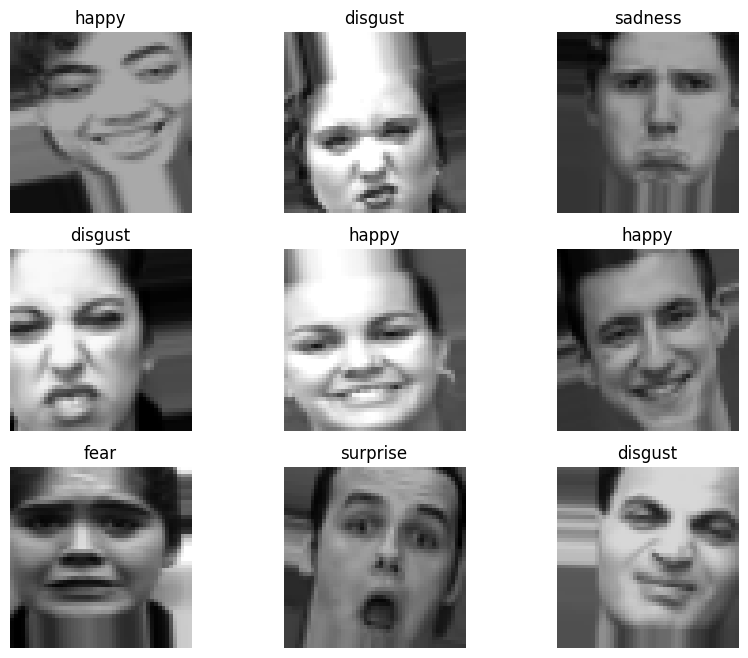

In [ ]:
# Map the emotion-categories
mapping = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4:'sadness', 5:'surprise'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,8))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")


In [ ]:
inputs = Input(shape=(48,48,3))
adam = Adam(lr=1e-4)


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,
                             verbose=0, mode='auto', min_delta=0.0001,
                               cooldown=0, min_lr=0)

In [ ]:
# CHANGE THE VALUE
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB6
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
base_model = EfficientNetB0(include_top=False, weights='imagenet',
                                drop_connect_rate=0.33, input_tensor=inputs)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(.35, name="top_dropout")(x)
x = Dense(1024, activation='relu')(x)

outputs = Dense(6, activation='softmax')(x)

model_dense2_output = Model(inputs = inputs, outputs = x)
model = Model(inputs=inputs , outputs = outputs)
model = Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 48, 48, 3)    0           ['normalization[0][0]']          
                                                                                            

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='/content/sample_data/model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)
# model.save('/content/sample_data/efficientmodel.hdf5')

In [ ]:
from tensorflow.keras.optimizers import SGD
lr = 1e-4
sgd = SGD(learning_rate = lr, momentum =.9, nesterov=False)
batch_size = 64
EPOCHS = 100
adam = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

In [ ]:
 model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#@title
# run
# # history = model.fit(X_train, y_train, epochs=100, batch_size=16,callbacks=[reduce_lr])
# hist=model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[reduce_lr], validation_data=(X_val,y_val),verbose=1)
# # history = model.fit(X_train, y_train, epochs=150, batch_size=16)
# histB6 = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
#                  steps_per_epoch=len(X_train) // batch_size,
#                  validation_data=(X_val, y_val),
#                  epochs=EPOCHS, callbacks = [reduce_lr])
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_val, y_val),
                 epochs=EPOCHS, callbacks = [reduce_lr])

Epoch 1/100
9/9 [==============================] - 55s 443ms/step - loss: 1.6356 - accuracy: 0.3802 - val_loss: 1.4254 - val_accuracy: 0.4564 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 1s 82ms/step - loss: 1.2631 - accuracy: 0.5417 - val_loss: 1.4615 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 1s 82ms/step - loss: 0.9230 - accuracy: 0.6629 - val_loss: 1.3396 - val_accuracy: 0.4698 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 1s 80ms/step - loss: 0.8716 - accuracy: 0.6761 - val_loss: 1.5918 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 1s 84ms/step - loss: 0.8145 - accuracy: 0.7235 - val_loss: 1.3202 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 1s 79ms/step - loss: 0.7130 - accuracy: 0.7538 - val_loss: 1.0757 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 1s 85ms/step - loss: 0.6346 -

In [ ]:
#@title


In [ ]:
# Split the dataset into two subsets (70%-30%). The first one will be used for training.

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=5)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

# The second subset will be split into validation and test set (50%-50%).
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)

print(f"X_valid has shape: {X_valid.shape}")
print(f"y_valid has shape: {y_valid.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_valid + X_test = {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (741, 48, 48, 3)
y_train has shape: (741, 6)

X_valid has shape: (93, 48, 48, 3)
y_valid has shape: (93, 6)

X_test has shape: (93, 48, 48, 3)
y_test has shape: (93, 6)

X_train + X_valid + X_test = 927 samples in total


In [ ]:
model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
batch_size = 64
filepath = "/content/drive/MyDrive/Data/tmp/checkpoint/weights.best.hdf5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint,  rlrop]
EPOCHS =200

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 200 epochs...

Epoch 1/200
11/11 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9749
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/Data/tmp/checkpoint/weights.best.hdf5


TypeError: ignored

In [ ]:
print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model.evaluate(X_test, y_test, verbose = 1)


Testing ------------
3/3 [==============================] - 0s 16ms/step - loss: 0.0162 - accuracy: 0.9892


In [ ]:
print('test loss:', loss)
print('test accuracy:', accuracy)

test loss: 0.016152380034327507
test accuracy: 0.9892473220825195


In [ ]:
#predict
y_pred = model.predict(X_test)

3/3 [==============================] - 1s 12ms/step


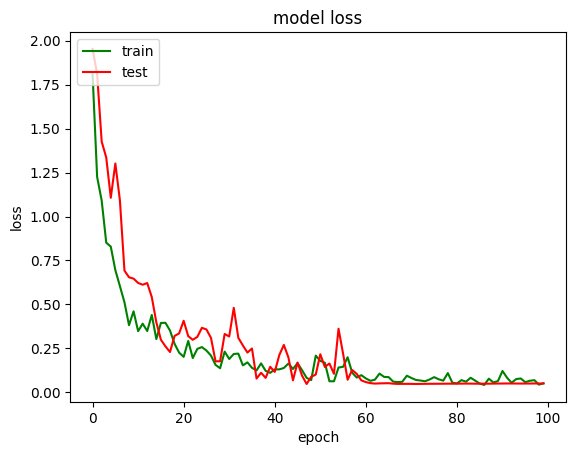

<Figure size 640x480 with 0 Axes>

In [ ]:
# summarize history for loss
import matplotlib.pyplot as plt

# plt.plot(hist.history['loss'])
plt.plot(histB6.history['loss'], 'g', label = 'B6-Loss')
plt.plot(histB6.history['val_loss'], 'r', label = 'B6-Val_Loss')
# plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('efficienetB6CK+.jpg')

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.plot(epochs, accB6, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('efficientnetB6CKacc.jpg')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('efficienetB6CKloss.jpg')

NameError: ignored

<class 'numpy.ndarray'>


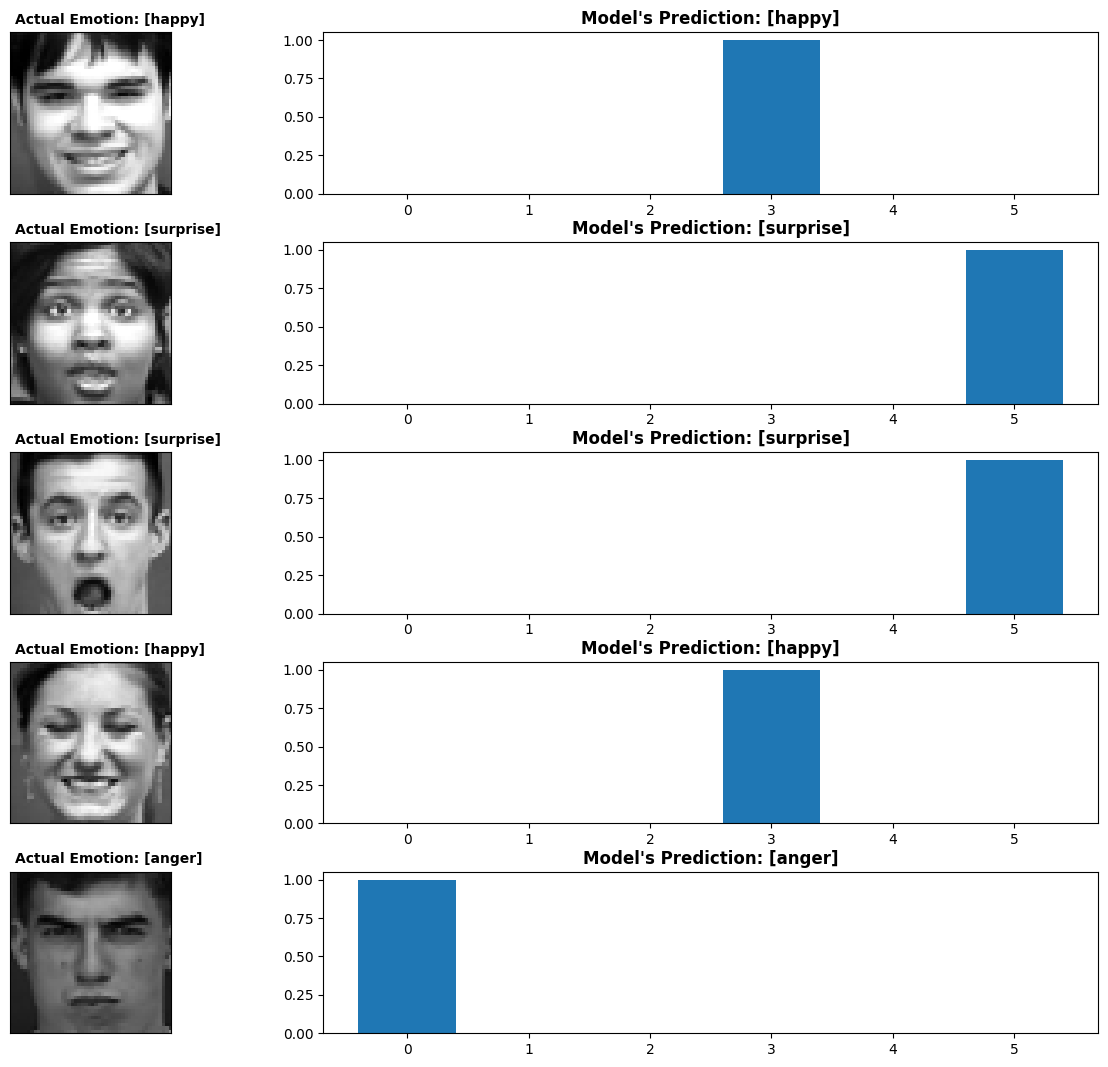

In [ ]:
samples = np.random.choice(len(X_test), 5)
print(type(samples))
samples = [0, 15,40,70,80]
predictions = model.predict(X_test[samples], verbose=0)

fig, axes = plt.subplots(len(samples), 2, figsize=(18, 13))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, X_test[samples], y_test[samples])):

    axes[i, 0].imshow(np.squeeze(image/255.))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(1., -3, f'Actual Emotion: [{mapping[np.argmax(label)]}]', weight='bold')

    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Model's Prediction: [{mapping[np.argmax(prediction)]}]", weight='bold')

In [ ]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle

In [ ]:
# new_label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
new_label = ['anger','disgust','fear','happy','sadness','surprise']
final_label = new_label
new_class = 6

In [ ]:
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2

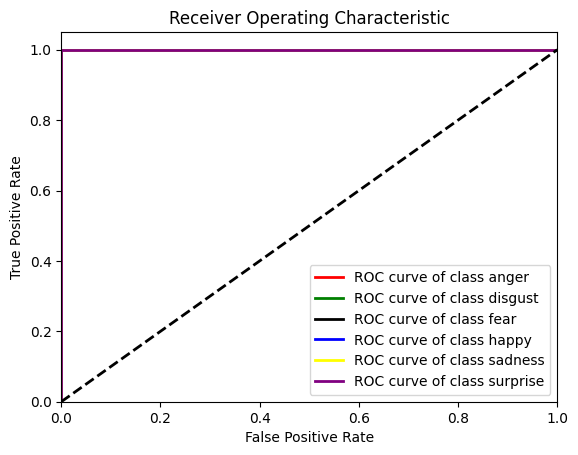

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test)
Pred=model.predict(X_test)
Pred

3/3 [==============================] - 0s 12ms/step


array([[5.70356650e-17, 1.73545967e-17, 7.94987340e-12, 1.00000000e+00,
        1.88071998e-19, 2.24814042e-17],
       [1.06856755e-14, 4.57642214e-12, 1.78786277e-14, 1.49891033e-17,
        8.01678376e-11, 1.00000000e+00],
       [2.53677688e-04, 1.33552649e-05, 9.97271001e-01, 2.64754111e-04,
        1.77530409e-03, 4.21851262e-04],
       [7.24921338e-05, 8.59236843e-06, 9.97930288e-01, 1.31835684e-03,
        5.69848518e-04, 1.00342426e-04],
       [1.25253870e-18, 1.06460759e-16, 4.08856054e-20, 8.47871591e-28,
        1.47776671e-14, 1.00000000e+00],
       [3.55195094e-17, 6.48329947e-20, 1.04429218e-14, 1.00000000e+00,
        2.12931234e-21, 1.44232466e-16],
       [6.68887723e-11, 4.99688824e-09, 1.00832259e-10, 4.15974893e-12,
        2.65858091e-08, 1.00000000e+00],
       [4.60041434e-01, 1.16066751e-03, 3.57764337e-04, 1.51493741e-05,
        5.38387418e-01, 3.75741001e-05],
       [9.30057286e-06, 5.94029586e-07, 9.96324956e-01, 3.61318444e-03,
        3.82291291e-05, 

In [ ]:
# mapping = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4:'sadness', 5:'surprise'}
labels_text = ['Anger', 'Disgust', 'Fear', 'Happy','Sadness', 'Surprise']
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

i=0
Y_test_l=[]
Pred_l=[]
while(i<len(Pred)):
  Y_test_l.append(int(np.argmax(y_test[i])))
  Pred_l.append(int(np.argmax(Pred[i])))
  i+=1

report=classification_report(Y_test_l, Pred_l, target_names=labels_text)
print(report)


              precision    recall  f1-score   support

       Anger       1.00      0.90      0.95        10
     Disgust       1.00      1.00      1.00        15
        Fear       1.00      1.00      1.00         9
       Happy       1.00      1.00      1.00        25
     Sadness       0.88      1.00      0.93         7
    Surprise       1.00      1.00      1.00        27

    accuracy                           0.99        93
   macro avg       0.98      0.98      0.98        93
weighted avg       0.99      0.99      0.99        93



<Axes: >

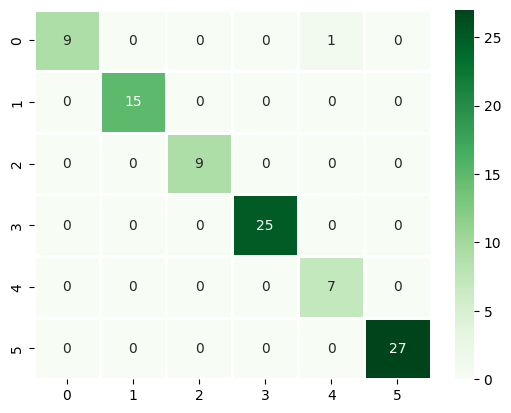

In [ ]:
from operator import index
results = confusion_matrix(Y_test_l, Pred_l)
cm_array_df = pd.DataFrame(results, index=labels_text, columns=labels_text)
import seaborn as sns

# sns.heatmap(results, annot=True,  cmap="Greens")
plt.savefig('efficientB6CK+.jpg')
# sns.heatmap(cm_array_df, annot=True,  cmap="Greens")

cf_matrix = confusion_matrix(Y_test_l, Pred_l)
sns.heatmap(cf_matrix, linewidths=1, annot=True, cmap="Greens")

In [ ]:
label_to_text = {'Afraid','Angry', 'Disgusted','Happy', 'Neutral', 'Sad', 'Surprised'}

results = confusion_matrix(Y_test_l, Pred_l, )
print(results)
# import seaborn as sns

# sns.heatmap(results, annot=True, cmap="YlGnBu")
# print("EFFICIENTNET KDEF")


# # #Transform to df for easier plotting
# cm_df = pd.DataFrame(results, index = label_to_text,
#                       columns = label_to_text
                    # )

[[ 9  0  0  0  1  0]
 [ 0 15  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0 25  0  0]
 [ 0  0  0  0  7  0]
 [ 0  0  0  0  0 27]]


In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_1',
 'rescaling',
 'normalization',
 'rescaling_1',
 'stem_conv_pad',
 'stem_conv',
 'stem_bn',
 'stem_activation',
 'block1a_dwconv',
 'block1a_bn',
 'block1a_activation',
 'block1a_se_squeeze',
 'block1a_se_reshape',
 'block1a_se_reduce',
 'block1a_se_expand',
 'block1a_se_excite',
 'block1a_project_conv',
 'block1a_project_bn',
 'block2a_expand_conv',
 'block2a_expand_bn',
 'block2a_expand_activation',
 'block2a_dwconv_pad',
 'block2a_dwconv',
 'block2a_bn',
 'block2a_activation',
 'block2a_se_squeeze',
 'block2a_se_reshape',
 'block2a_se_reduce',
 'block2a_se_expand',
 'block2a_se_excite',
 'block2a_project_conv',
 'block2a_project_bn',
 'block2b_expand_conv',
 'block2b_expand_bn',
 'block2b_expand_activation',
 'block2b_dwconv',
 'block2b_bn',
 'block2b_activation',
 'block2b_se_squeeze',
 'block2b_se_reshape',
 'block2b_se_reduce',
 'block2b_se_expand',
 'block2b_se_excite',
 'block2b_project_conv',
 'block2b_project_bn',
 'block2b_drop',
 'block2b_add',
 'block3a_expand_

XGBOOST

In [ ]:
#with xgboost
import xgboost
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train_xg = model_dense2_output.predict(X_train)
X_test_xg = model_dense2_output.predict(X_test)
print(np.array(X_train_xg).shape)
print(np.array(y_train).shape)

3/3 [==============================] - 0s 10ms/step
(741, 1024)
(741, 6)


In [ ]:
y_train[0:10,:]
y_train1 = [np.argmax(y, axis=None) for y in y_train]
len(y_train1)
y_train1 = np.array(y_train1)
y_train1.shape

(741,)

In [ ]:
y_train1 =y_train.reshape((741*6,))
y_train1.shape

(4446,)

In [ ]:
print(X_test.shape)
print(y_test.shape)


(93, 48, 48, 3)
(93, 6)


In [ ]:
z = np.concatenate([np.array(X_train_xg).reshape(741,1024),np.array(y_train1).reshape(741,1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('train_xg.csv',index=False)

ValueError: ignored

In [ ]:
y_test1 = [np.argmax(y, axis=None) for y in y_test]
len(y_test1)
y_test1 = np.array(y_test1)
y_test1.shape

z = np.concatenate([np.array(X_test_xg).reshape(279,1024),np.array(y_test1).reshape(279,1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('test_xg.csv',index=False)

ValueError: ignored

In [ ]:
train = pd.read_csv('train_xg.csv')
train_y = train['1024'].astype('int')
train_x = train.drop(['1024'],axis=1)
dataset = xgboost.DMatrix(train_x, label=train_y)
watchlist = [(dataset, 'train')]
params = {'max_depth':7, 'eta':0.2, 'silent':1, 'num_class':6,'objective':'multi:softmax' }
model_xg = xgboost.train(params, dataset, num_boost_round=200, evals=watchlist)

[0]	train-merror:0.003086
[1]	train-merror:0
[2]	train-merror:0
[3]	train-merror:0
[4]	train-merror:0
[5]	train-merror:0
[6]	train-merror:0
[7]	train-merror:0
[8]	train-merror:0
[9]	train-merror:0
[10]	train-merror:0
[11]	train-merror:0
[12]	train-merror:0
[13]	train-merror:0
[14]	train-merror:0
[15]	train-merror:0
[16]	train-merror:0
[17]	train-merror:0
[18]	train-merror:0
[19]	train-merror:0
[20]	train-merror:0
[21]	train-merror:0
[22]	train-merror:0
[23]	train-merror:0
[24]	train-merror:0
[25]	train-merror:0
[26]	train-merror:0
[27]	train-merror:0
[28]	train-merror:0
[29]	train-merror:0
[30]	train-merror:0
[31]	train-merror:0
[32]	train-merror:0
[33]	train-merror:0
[34]	train-merror:0
[35]	train-merror:0
[36]	train-merror:0
[37]	train-merror:0
[38]	train-merror:0
[39]	train-merror:0
[40]	train-merror:0
[41]	train-merror:0
[42]	train-merror:0
[43]	train-merror:0
[44]	train-merror:0
[45]	train-merror:0
[46]	train-merror:0
[47]	train-merror:0
[48]	train-merror:0
[49]	train-merror:0
[50

In [ ]:
test = pd.read_csv('test_xg.csv')
test_y = test['1024'].astype('int')
test_x = test.drop(['1024'],axis=1)

In [ ]:
test_x = xgboost.DMatrix(test_x)
result = model_xg.predict(test_x)
predicted_labels = model_xg.predict(test_x)

In [ ]:
from sklearn.metrics import accuracy_score
# evaluate performance
yhat = model_xg.predict(test_x)
score = accuracy_score(test_y, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.993


In [ ]:
print(metrics.classification_report(test_y, result, target_names =labels_text))
print(metrics.confusion_matrix(test_y, result))

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        32
     Disgust       0.98      1.00      0.99        62
        Fear       0.95      1.00      0.97        19
       Happy       1.00      1.00      1.00        69
     Sadness       1.00      0.96      0.98        26
    Surprise       1.00      0.99      0.99        71

    accuracy                           0.99       279
   macro avg       0.99      0.99      0.99       279
weighted avg       0.99      0.99      0.99       279

[[32  0  0  0  0  0]
 [ 0 62  0  0  0  0]
 [ 0  0 19  0  0  0]
 [ 0  0  0 69  0  0]
 [ 0  0  1  0 25  0]
 [ 0  1  0  0  0 70]]


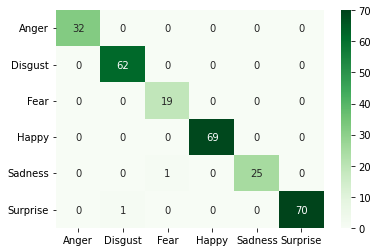

In [ ]:
from operator import index
results = confusion_matrix(test_y, result)
cm_array_df = pd.DataFrame(results, index=labels_text, columns=labels_text)
import seaborn as sns

# sns.heatmap(results, annot=True,  cmap="Greens")
plt.savefig('efficientB6CK+.jpg')
sns.heatmap(cm_array_df, annot=True,  cmap="Greens")

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_y, result)
print(cnf_matrix)

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        32
     Disgust       0.98      1.00      0.99        62
        Fear       0.95      1.00      0.97        19
       Happy       1.00      1.00      1.00        69
     Sadness       1.00      0.96      0.98        26
    Surprise       1.00      0.99      0.99        71

    accuracy                           0.99       279
   macro avg       0.99      0.99      0.99       279
weighted avg       0.99      0.99      0.99       279

[[32  0  0  0  0  0]
 [ 0 62  0  0  0  0]
 [ 0  0 19  0  0  0]
 [ 0  0  0 69  0  0]
 [ 0  0  1  0 25  0]
 [ 0  1  0  0  0 70]]


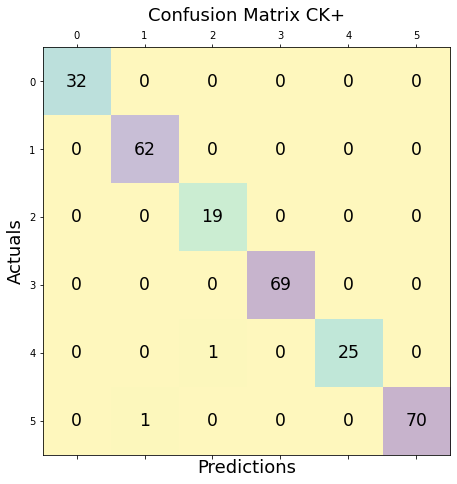

<Figure size 432x288 with 0 Axes>

In [ ]:
print(metrics.classification_report(test_y, result, target_names=labels_text))
print(metrics.confusion_matrix(test_y, result))

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cnf_matrix, cmap=plt.cm.viridis_r, alpha=0.3)
for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cnf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix CK+', fontsize=18)
plt.show()
plt.savefig('efficienetxgboostck.jpg')


In [ ]:
img_anger ='/content/drive/MyDrive/CKPlus48/anger/S010_004_00000018.png'

In [ ]:
# anger = cv2.imread('/content/drive/MyDrive/CKPlus48/anger/S010_004_00000018.png')
disgust ='/content/drive/MyDrive/CKPlus48/disgust/S005_001_00000010.png'
img_disgust = cv2.resize(disgust,(48,48))
plt.imshow(img_disgust)

TypeError: ignored

In [ ]:
# tf.keras.preprocessing.image.img_to_array
## Importing All the usefull libraries
import tensorflow as tf2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from tensorflow.keras import preprocessing
def ShowMeWhatYouLearnt(Image, layer, MyModel):
    img = img_to_array(Image)
    img = np.expand_dims(img, 0)
    ### preprocessing for img for vgg16
    img = tf2.keras.applications.vgg16.preprocess_input(img)

    ## Now lets define a model which will help us
    ## see what vgg16 sees
    inputs = MyModel.inputs
    outputs = MyModel.layers[layer].output
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    ## let make predictions to see what the Cnn sees
    featureMaps = model.predict(img)

    ## Plotting Features
    for maps in featureMaps:
        plt.figure(figsize=(20,20))
        pltNum = 1

        for a in range(8):
            for b in range(8):
                plt.subplot(8, 8, pltNum)
                plt.imshow(maps[: ,: ,pltNum - 1], cmap='gray')
                pltNum += 1

        plt.show()

In [ ]:
ShowMeWhatYouLearnt(img_anger,20, model)

ValueError: ignored

In [ ]:
# Create an explainer object
explainer = shap.Explainer(model_xg)

# Calculate SHAP values for a set of samples
shap_values = explainer(train_x)
